In [1]:
!pip install gensim
!pip install glove-python-binary



     |████████████████████████████████| 952kB 7.5MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
base_dir = root_dir 
checkpoint_dir = base_dir +'/data'

Mounted at /content/drive


In [47]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import string
import spacy
import re
import nltk
from glove import Corpus, Glove
from nltk import tokenize, sent_tokenize, word_tokenize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


nltk.download('punkt')

pd.set_option('display.max_colwidth',None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:

NUM_LABELS = 2
DATA_PATH = base_dir + 'IMDB Dataset.csv'

In [5]:
# export
def read_data(path):
    """
    returns a pandas DataFrame from path   
    """
    df = pd.read_csv(path)
    return df

In [6]:
df = read_data(DATA_PATH)
df = df.reindex(np.random.permutation(df.index))
df.head()

review sentiment
849    A terminally dull mystery-thriller, which may ...  negative
13575  I will admit my ignorance of this film's exist...  positive
20252  Strange enough, all the previous comments mere...  positive
23678  In her first nonaquatic role, Esther Williams ...  positive
226    Shamefull as it may be, this movie actually ma...  negative

In [7]:
spacy_nlp = spacy.load("en_core_web_sm")
table =str.maketrans('','',re.sub('\'', '', string.punctuation)) # without "'"
# remove stop words with exceptions
def remove_stopwords(input_text):

    stopwords_list = spacy.lang.en.stop_words.STOP_WORDS
    # Words which might indicate a certain sentiment we want to keep them
    white_list = ["not", "no", "n't"]
    words = input_text.lower().split()
    clean_words = [word for word in words if (
        word not in stopwords_list or word in white_list) and 
        # word.isalpha() and 
        len(word) > 1
        ]
    return " ".join(clean_words)
# remove mentions


def remove_br(text):
    return re.sub(r'<br /><br />', ' ', text)

def remove_punctuation(text):

    return text.translate(table)



df['review'] = df['review'].apply(remove_stopwords).apply(remove_br).apply(remove_punctuation)
df.head()

review sentiment
849    terminally dull mysterythriller sound pretty s...  negative
13575  admit ignorance film's existence saw advertise...  positive
20252  strange enough previous comments merely descri...  positive
23678  nonaquatic role esther williams plays school t...  positive
226    shamefull be movie actually videomarket bringi...  negative

Word embeddings could provide a useful and efficient means for document clustering. Document embeddings is created by averaging the vectors of each of the words in the document. 

In [8]:
documents = [gensim.utils.simple_preprocess(df['review'].iloc[i]) for i in range(len(df))]
corpus = Corpus()
corpus.fit(documents, window=5)
glove = Glove(no_components=300, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=10, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
print("Glove embeddings trained.")

doc_vectors = []
for doc in documents:
    vec = np.zeros(glove.word_vectors[glove.dictionary['the']].shape)
    for token in doc:
      vec += glove.word_vectors[glove.dictionary[token]]
    if len(doc) > 0:
      vec = vec/len(doc)
    doc_vectors.append(vec)
    
print("Processed documents = ",len(doc_vectors))

Performing 10 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Glove embeddings trained.
Processed documents =  27502


In [9]:
print(np.asarray(doc_vectors).shape)
doc_vectors

(27502, 300)


[array([ 7.66382087e-02,  8.15425972e-03,  2.16617543e-02, -5.18373658e-02,
        -2.71194021e-03,  2.19751753e-02, -6.28434102e-02,  1.27073702e-02,
        -6.96821299e-02,  5.22705536e-02, -6.24828355e-02,  1.61330536e-03,
         6.01214706e-02, -2.35615177e-02,  6.81310826e-02, -1.73080222e-02,
        -1.45733031e-02,  8.69295443e-02,  1.06330630e-02,  1.04098627e-01,
        -9.75406106e-03,  1.20360241e-02, -2.81302767e-02,  1.53011769e-02,
        -8.38845865e-02, -9.02106091e-02, -1.92248483e-02,  5.06122912e-02,
        -6.50965856e-02, -5.84930183e-02, -1.17707571e-02, -7.83772955e-02,
         8.36924636e-02,  2.76847793e-02, -7.72625113e-02, -1.59973621e-02,
         2.58594271e-02,  4.88823873e-02,  5.61067939e-02, -2.13924440e-02,
         3.12078526e-02, -2.91535912e-02, -5.08223000e-02,  3.81667998e-02,
         7.63770796e-02, -4.96723262e-02,  9.80693266e-02,  5.71380552e-03,
         6.16473918e-03, -1.14860292e-01, -4.81631195e-02,  2.06122584e-02,
        -1.2

Text(0, 0.5, 'Proportion of Explained Variance')

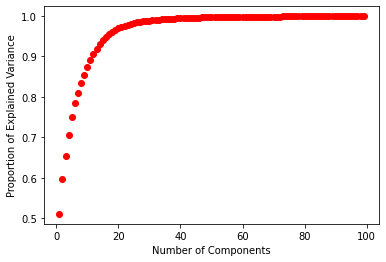

In [10]:


explained_var = []
for components in range(1,100,1):
  pca = PCA(n_components=components)
  pca.fit(doc_vectors)
  explained_var.append(pca.explained_variance_ratio_.sum())

plt.plot(range(1,100,1),explained_var,"ro")
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Explained Variance")

Explained variance of the PCA step: 97%


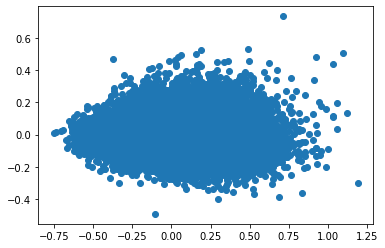

In [12]:

from sklearn.decomposition import PCA
import seaborn as sns

components = 20

palette = np.array(sns.color_palette("hls", 120))

pca = PCA(n_components=components)
pca.fit(doc_vectors)
pca_dtm = pca.transform(doc_vectors)

plt.scatter(pca_dtm[:,0],pca_dtm[:,1])

explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the PCA step: {}%".format(
    int(explained_variance * 100)))

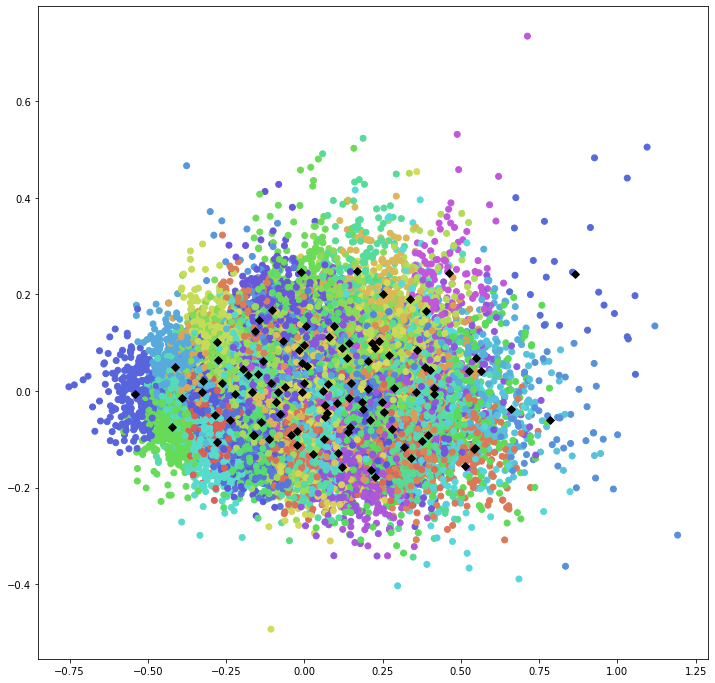

In [31]:
from sklearn.cluster import KMeans
palette = np.array(sns.color_palette("hls", 125))

model = KMeans(n_clusters=100,max_iter=100, random_state=11)
clustered = model.fit(pca_dtm)
centroids = model.cluster_centers_
y = model.predict(pca_dtm)
plt.figure(figsize=(12,12))
ax = plt.subplot()

ax.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[y.astype(np.int)])
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

ax.scatter(centroids_x, centroids_y, marker='D', c='black', s=30)
plt.show()

In [32]:
KM_clustered = df.copy()
KM_clustered.loc[:,'Cluster'] = model.labels_ # labeliki do danych

# KM_pca.loc[:,'Cluster'] = KM_clusters.labels_ 
# KM_clustered = pd.concat([KM_clustered,CIF,TARGET,NPS],axis=1)
# KM_plot = pd.concat([KM_pca,NPS],axis=1 ,join='inner' )

In [33]:
KM_clust_sizes = KM_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
# KM9_clust_sizes['Cluster'].rename(dict_clust.values())
KM_clust_sizes[70:]

KM_size
Cluster         
70           300
71           246
72           171
73            60
74           334
75           198
76           216
77           471
78           489
79            25
80           239
81           519
82           299
83           348
84           259
85           318
86           662
87           133
88           546
89           295
90           360
91            87
92           317
93           236
94           150
95           309
96           213
97           302
98           140
99           106

In [35]:
KM_clustered[KM_clustered.Cluster==79]

review sentiment  Cluster
26923  movie alltime favorites think sean penn great ...  positive       79
27447  horror movie intelligent cast director great v...  positive       79
27460  great cast great acting great music character ...  positive       79
24482  doubt funniest entertaining movies seen enjoye...  positive       79
26653  thought actually best vampire movie i've seen ...  positive       79
26260  it´s movie tv once mean it´s good it´s little ...  positive       79
27475  think it's greatest movies made i've seen many...  positive       79
27382  watched movie second time enjoyed time emotion...  positive       79
27474  cool movie ending movie bit defined play's end...  positive       79
27472  movie turned better expected be parts pretty f...  positive       79
26899  earth best movie funny it's sweet too good plo...  positive       79
2471   movie bad it's good bad story bad acting bad m...  negative       79
27233  wonderful movie growing italian family definit...  positive       79
27467  thought quiet good movie fun watch it liked be...  positive       79
27220  surprised good words movie time the 80's enter...  positive       79
2497                         movie terrible good effects  negative       79
27218  movie time favorite movie great acting cute gu...  positive       79
27428  best movies i've seen acting good plot solid m...  positive       79
26891  great movie thought good was great special eff...  positive       79
27434  actually favorite films recommend watches it g...  positive       79
27232  movie funny amitabh bachan govinda absolutely ...  positive       79
26660  talk bad movie nonsense matter fact best movie...  positive       79
25968  excellent arnold movie futuristic movie great ...  positive       79
27496          good film funny film no good ernest films  positive       79
26849  long time haven't seen good fantasy movie magi...  positive       79

In [44]:
KM_clust_sizes[KM_clust_sizes.KM_size < 80] # smallest cluster

KM_size
Cluster         
61            76
73            60
79            25

In [41]:
#let see cluster some small clusters
cl_list = list(KM_clust_sizes[KM_clust_sizes.KM_size < 80].index)
KM_clustered_selected =  KM_clustered[KM_clustered.Cluster.isin(cl_list)]
KM_clustered_selected

review sentiment  Cluster
25328  movie all great actors good dialog drama comed...  positive       61
25944  best comedy writing parody soap brilliant cast...  positive       61
26904  best bond game systems best bond movie time do...  positive       61
22892  enjoyed film muchtobey maguire gives terrific ...  positive       61
27477  favorite movie great story was i'd like able b...  positive       73
...                                                  ...       ...      ...
26046  possibly perfect film seen acting adaptation d...  positive       61
27496          good film funny film no good ernest films  positive       79
26982  hate it think one's overrated love jackie's fi...  positive       73
25915  movie seen times time 6 seen english version w...  positive       73
26849  long time haven't seen good fantasy movie magi...  positive       79

[161 rows x 3 columns]

In [68]:
print(KM_clustered.sentiment.value_counts(normalize = True))
print(pd.crosstab(KM_clustered_selected.sentiment,KM_clustered_selected.Cluster,normalize='columns').T.reset_index())
cross = pd.crosstab(KM_clustered_selected.sentiment,KM_clustered_selected.Cluster,normalize='columns').T.reset_index()
cross
# cross.drop(["sentiment"],axis=1,inplace = True)

positive    0.909025
negative    0.090975
Name: sentiment, dtype: float64
sentiment  Cluster  negative  positive
0               61  0.052632  0.947368
1               73  0.466667  0.533333
2               79  0.080000  0.920000


sentiment  Cluster  negative  positive
0               61  0.052632  0.947368
1               73  0.466667  0.533333
2               79  0.080000  0.920000

         word  count
0       movie     57
1        good     27
2       great     26
3          it     20
4          's     15
5      acting     12
6       story     10
7        best      9
8        seen      8
9           i      7
10       time      7
11        not      6
12     movies      6
13        've      6
14       plot      6
15      funny      6
16        bad      6
17    effects      5
18      films      4
19  recommend      4
20    moments      4
21    thought      4
22        n't      4
23      think      3
24       film      3
25       like      3
26         10      3
27      watch      3
28         no      3
29        too      3


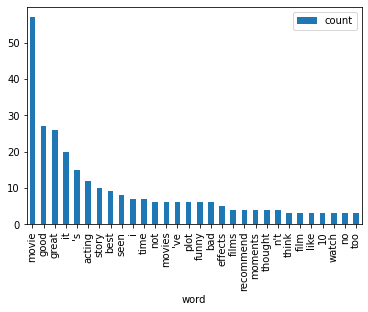

In [74]:
KM_clustered_words = KM_clustered[KM_clustered.Cluster==79]
corpus = KM_clustered_words['review'].tolist()
words = [tokenize.word_tokenize(x) for x in corpus]
words = [y for x in words for y in x]
word_freq = pd.DataFrame(nltk.FreqDist(words).most_common(30), columns=['word','count'])
print(word_freq)

word_freq.plot.bar(x='word')